In [1]:
import os
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')

kaggle.json


In [2]:
# Download data
!pip install -q kaggle
!kaggle datasets download -d hereisburak/pins-face-recognition

100% 371M/372M [00:10<00:00, 34.2MB/s]
100% 372M/372M [00:10<00:00, 35.6MB/s]


In [3]:
!unzip '/content/pins-face-recognition.zip' -d '/content/dataset/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner37_964.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: /content/dataset/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: /content/dataset/105_classes_pins_dat

In [ ]:
!pip install keras_applications
!pip install keras_squeezenet

In [4]:
import os
import gc
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import layers
import keras.backend as K
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization, Conv2D,AvgPool2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Convolution2D
from tensorflow.keras.layers import ReLU, DepthwiseConv2D, Reshape, Permute, MaxPool2D, concatenate, Add

from keras.callbacks import ReduceLROnPlateau

from shutil import copyfile
from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

pd.set_option('display.max_colwidth', -1)

%matplotlib inline

<ipython-input-4-7131387a9641>:45: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
os.makedirs('/content/dataset3/105_classes_pins_dataset')

In [44]:
client = ['client1', 'client2', 'client3', 'client4']

In [45]:
DATADIR = '/content/dataset/105_classes_pins_dataset'
TARGETPATH = '/content/dataset2/105_classes_pins_dataset'
ClientPath = '/content/dataset3/105_classes_pins_dataset'
CATEGORIES = [name for name in os.listdir(DATADIR) if os.path.isdir(os.path.join(DATADIR, name))]

In [46]:
def divideimage(path, imgg, category):
  img = cv2.imread(path)
  h, w, channels = img.shape
  
  client1_path = os.path.join(ClientPath, client[0], category)
  client2_path = os.path.join(ClientPath, client[1], category)
  client3_path = os.path.join(ClientPath, client[2], category)
  client4_path = os.path.join(ClientPath, client[3], category)

  if((os.path.isdir(client1_path)) == False):
    os.makedirs(client1_path)

  if((os.path.isdir(client2_path)) == False):
    os.makedirs(client2_path)

  if((os.path.isdir(client3_path)) == False):
    os.makedirs(client3_path)

  if((os.path.isdir(client4_path)) == False):
    os.makedirs(client4_path)
  
  half = w//2
  chalf = half//2
  
  left_part = img[:, :chalf]
  left_center_part = img[:, chalf:half]
  right_center_part = img[:, half:half+chalf]
  right_part = img[:, half+chalf:half+half]
  
  # saving all the images
  # cv2.imwrite() function will save the image
  # into your pc

  client1_path_img = os.path.join(ClientPath, client[0], category, imgg)
  client2_path_img = os.path.join(ClientPath, client[1], category, imgg)
  client3_path_img = os.path.join(ClientPath, client[2], category, imgg)
  client4_path_img = os.path.join(ClientPath, client[3], category, imgg)
  cv2.imwrite(client1_path_img, left_part)
  cv2.imwrite(client2_path_img, left_center_part)
  cv2.imwrite(client3_path_img, right_center_part)
  cv2.imwrite(client4_path_img, right_part)

In [47]:
import cv2
def create_client_data():
  for category in CATEGORIES: #Running for all 105 categories
    path = os.path.join(DATADIR,category) # Creating paths of each category
    target = os.path.join(ClientPath,category)
    #if((os.path.isdir(target)) == False):
      #os.makedirs(target)
    for img in os.listdir(path):  # iterate over each image per class
      target = os.path.join(ClientPath,category)
      target = os.path.join(target,img)
      imgg = os.path.join(path,img)
      divideimage(imgg, img, category)
create_client_data()

In [48]:
DATADIR_C1 = '/content/dataset3/105_classes_pins_dataset/client1'
DATADIR_C2 = '/content/dataset3/105_classes_pins_dataset/client2'
DATADIR_C3 = '/content/dataset3/105_classes_pins_dataset/client3'
DATADIR_C4 = '/content/dataset3/105_classes_pins_dataset/client4'

In [49]:
import matplotlib.pyplot as plt
def showImage(client):
  for category in CATEGORIES: #Running for all 105 categories
    path = os.path.join(client,category) #Creating paths of each category
    for img in os.listdir(path):  # iterate over each image per class
        img_array = cv2.imread(os.path.join(path,img))  # convert to array. Default color space of CV2 image is BGR
        im_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) #Converting BGR to RGB
        return im_rgb

        break  # we just want one for now so break
    break  #...and one more!

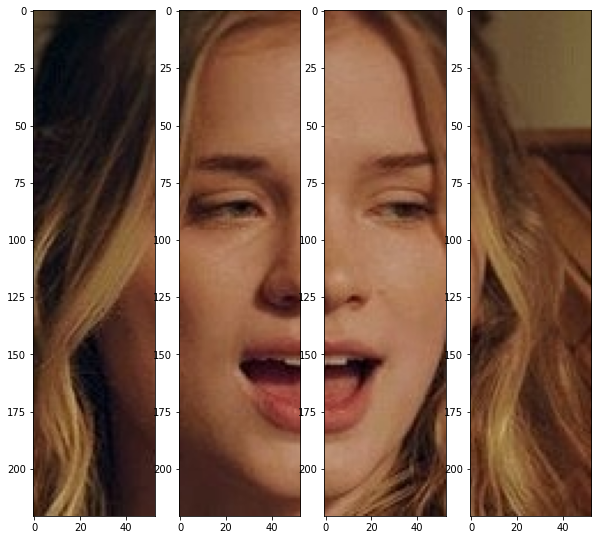

In [50]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 4, 1)
plt.imshow(showImage(DATADIR_C1))
fig.add_subplot(1, 4, 2)
plt.imshow(showImage(DATADIR_C2))
fig.add_subplot(1, 4, 3)
plt.imshow(showImage(DATADIR_C3))
fig.add_subplot(1, 4, 4)
plt.imshow(showImage(DATADIR_C4))

In [57]:
imagesc1 = os.listdir('/content/dataset3/105_classes_pins_dataset/client1')
imagesc2 = os.listdir('/content/dataset3/105_classes_pins_dataset/client2')
imagesc3 = os.listdir('/content/dataset3/105_classes_pins_dataset/client3')
imagesc4 = os.listdir('/content/dataset3/105_classes_pins_dataset/client4')

In [68]:
def processdata(path, client_path):
  images = []
  classes = []
  paths = []
  for dirs in path:
      images_ = os.listdir(client_path+'/'+dirs)
      for image in images_:
          images.append(image)
          paths.append(client_path+'/'+dirs+'/'+image)
          classes.append(dirs)
  return paths, classes, images

In [69]:
train_df_c1 = pd.DataFrame()
train_df_c1['paths'], train_df_c1['classes'], train_df_c1['images'] = processdata(imagesc1, DATADIR_C1)

train_df_c2 = pd.DataFrame()
train_df_c2['paths'], train_df_c2['classes'], train_df_c2['images'] = processdata(imagesc2, DATADIR_C2)

train_df_c3 = pd.DataFrame()
train_df_c3['paths'], train_df_c3['classes'], train_df_c3['images'] = processdata(imagesc3, DATADIR_C3)

train_df_c4 = pd.DataFrame()
train_df_c4['paths'], train_df_c4['classes'], train_df_c4['images'] = processdata(imagesc4, DATADIR_C4)

In [70]:
train_df_c1.head()

,paths,classes,images
0,/content/dataset3/105_classes_pins_dataset/client1/pins_Elizabeth Lail/Elizabeth Lail36_1158.jpg,pins_Elizabeth Lail,Elizabeth Lail36_1158.jpg
1,/content/dataset3/105_classes_pins_dataset/client1/pins_Elizabeth Lail/Elizabeth Lail120_1072.jpg,pins_Elizabeth Lail,Elizabeth Lail120_1072.jpg
2,/content/dataset3/105_classes_pins_dataset/client1/pins_Elizabeth Lail/Elizabeth Lail179_1108.jpg,pins_Elizabeth Lail,Elizabeth Lail179_1108.jpg
3,/content/dataset3/105_classes_pins_dataset/client1/pins_Elizabeth Lail/Elizabeth Lail201_1122.jpg,pins_Elizabeth Lail,Elizabeth Lail201_1122.jpg
4,/content/dataset3/105_classes_pins_dataset/client1/pins_Elizabeth Lail/Elizabeth Lail107_1058.jpg,pins_Elizabeth Lail,Elizabeth Lail107_1058.jpg


In [71]:
train_df_c1.count()

paths      17534
classes    17534
images     17534
dtype: int64

In [72]:
print('Train samples count: ', len(train_df_c1))
train_df_c1.columns

Train samples count:  17534


Index(['paths', 'classes', 'images'], dtype='object')

In [73]:
print('Class Count: ',len(train_df_c1['classes'].value_counts()))
train_df_c1['classes'].value_counts()

Class Count:  105


pins_Leonardo DiCaprio     237
pins_Robert Downey Jr      233
pins_Katherine Langford    226
pins_Alexandra Daddario    225
pins_elizabeth olsen       221
                          ... 
pins_Morgan Freeman        105
pins_Brian J. Smith        102
pins_Cristiano Ronaldo     98 
pins_Mark Zuckerberg       95 
pins_Lionel Messi          86 
Name: classes, Length: 105, dtype: int64

In [74]:
train_df_c1.isna().sum()

paths      0
classes    0
images     0
dtype: int64

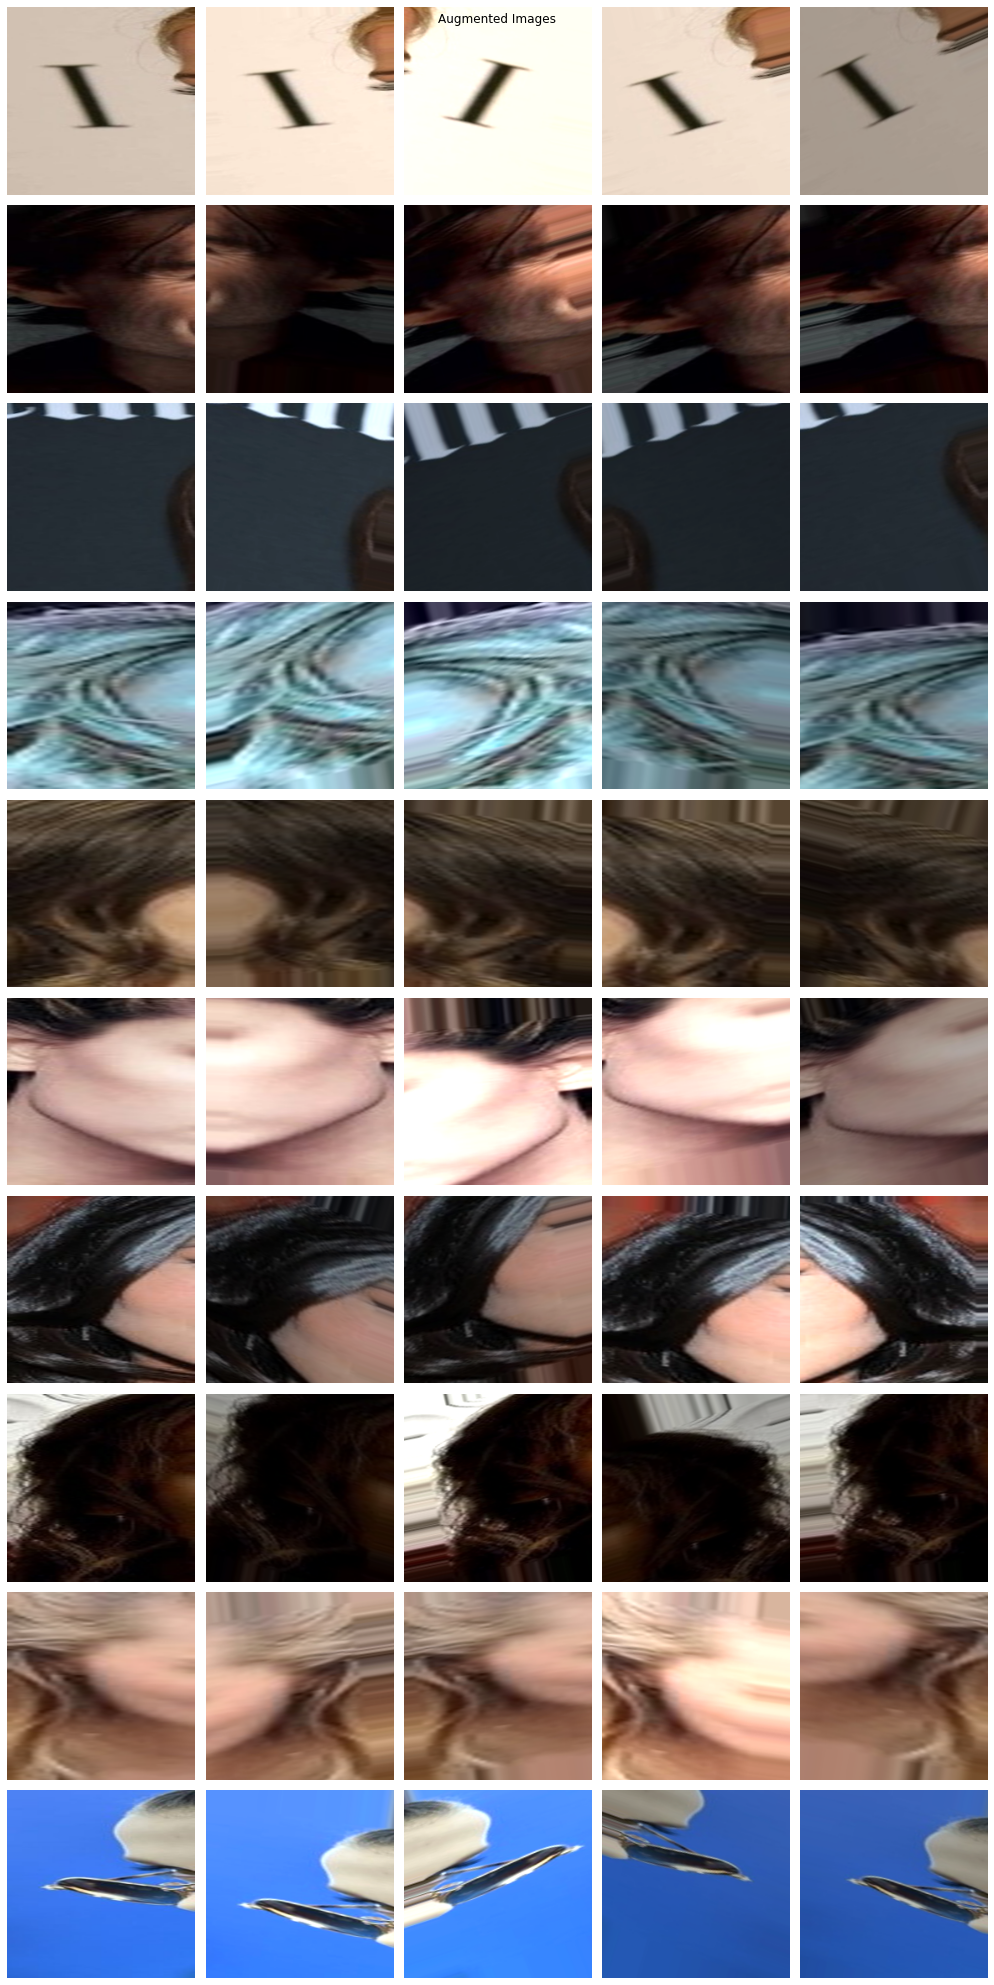

In [75]:
def plot_augimages(paths, datagen):
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        samples = expand_dims(data, 0)
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8')
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

    
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
) 
plot_augimages(np.random.choice(train_df_c1['paths'],10), datagen)

In [76]:
y_count=len(train_df_c1['classes'].unique())

In [77]:
import random
def FlattenInput(data):
  BS = random.getrandbits(4)
  return data.flatten(), BS

def RandomizedBinary(data, BS):
  a = '{0:016b}'.format(data)
  b = '{0:016b}'.format(BS)
  max_len = max(len(a), len(b))
  a = a.zfill(max_len)
  b = b.zfill(max_len)
  result = ''
  c = 0
  
  for i in range(max_len - 1, -1, -1):
    r = c
    r += 1 if a[i] == '1' else 0
    r += 1 if b[i] == '1' else 0
    result = ('1' if r % 2 == 1 else '0') + result
    c = 0 if r < 2 else 1
  
  if c != 0:
    result = '1' + result
  result = int(result, 2)
  return result

def ReshapeBack(nw, nx, ny, nz, arr_1d):
  arr_nd = np.empty((nw,nx,ny,nz))
  count = 0
  for l in range(nw):
    for k in range(nx):
      for j in range(ny):
        for i in range(nz):
          arr_nd[l,k,j,i] = arr_1d[count]
          count += 1
  return arr_nd

In [78]:
def LatentBlock(xc):
  arr_1d, BS = FlattenInput(XC1)
  randomized_1d = np.empty((arr_1d.shape[0]))
  for i in range(arr_1d.shape[0]):
    randomized_1d[i] = RandomizedBinary(arr_1d[i], BS)

  randomized_X1 = ReshapeBack(XC1.shape[0], XC1.shape[1], XC1.shape[2], XC1.shape[3], randomized_1d)
  return randomized_X1

In [79]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,ReLU
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras import Model

In [80]:
# creating the Conv-Batch Norm block

def conv_bn_relu(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters,
             kernel_size = kernel_size,
             strides=strides,
             use_bias = False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x

In [81]:
# creating the Block-1
def Block_1(x):
  x = conv_bn_relu(x, filters =32, kernel_size =3, strides=2)
  x = conv_bn_relu(x, filters =32, kernel_size =3, strides=1)
  x = conv_bn_relu(x, filters =64, kernel_size =1, strides=1)
  x = conv_bn_relu(x, filters =64, kernel_size =3, strides=2)
  x = conv_bn_relu(x, filters =80, kernel_size =1, strides=1)
  x = conv_bn_relu(x, filters =192, kernel_size =3, strides=1)
  x = MaxPooling2D(pool_size=(2,2))(x)
  return x

In [82]:
# creating the Block-2
def Block_2(x):
  x = conv_bn_relu(x, filters =64, kernel_size =1, strides=1)
  x = conv_bn_relu(x, filters =32, kernel_size =1, strides=1)
  x = conv_bn_relu(x, filters =32, kernel_size =1, strides=1)
  return x

In [83]:
# creating the Block-3
def Block_3(x):
  x = conv_bn_relu(x, filters =48, kernel_size =1, strides=1)
  x = conv_bn_relu(x, filters =64, kernel_size =1, strides=1)
  return x

In [84]:
# creating the Block-4
def Block_4(x):
  x = MaxPooling2D(pool_size=(1,1))(x)
  x = conv_bn_relu(x, filters =32, kernel_size =1, strides=1)
  return x

In [85]:
# creating the Block-5
def Block_5(x):
  x = conv_bn_relu(x, filters =64, kernel_size =1, strides=1)
  return x

In [86]:
def Concatenate(x2, x3, x4, x5):
  x = tf.keras.layers.Concatenate()([x2, x3, x4, x5])
  return x

In [87]:
def RepeatedBlocks(x):
  x2 = Block_2(x)
  x3 = Block_3(x)
  x4 = Block_4(x)
  x5 = Block_5(x)
  xc = Concatenate(x2, x3, x4, x5)
  #LatentBlock(xc)
  return xc

In [88]:
class CustomCNN:
    @staticmethod
    def build():
      input = Input(shape = (160,160,3))
      x = Block_1(input)
      x1 = RepeatedBlocks(x)
      x2 = RepeatedBlocks(x1)
      x3 = RepeatedBlocks(x2)
      x4 = RepeatedBlocks(x3)
      x5 = RepeatedBlocks(x4)
      x6 = RepeatedBlocks(x5)
      x7 = RepeatedBlocks(x6)
      x8 = RepeatedBlocks(x7)
      x9 = Flatten()(x8)
      x9 = Dense(y_count, activation="softmax")(x9)
      model = Model(inputs=input, outputs=x9)
      return model

In [89]:
comms_round = 6
totalclients = 4

In [90]:
datagen_train = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
datagen_test = ImageDataGenerator(rescale=1/255)

In [93]:
def networkTraining(X, y, local_model, split = 0.2, epochs = 30):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
  train_generator = datagen_train.flow_from_dataframe(
      X_train,  # This is the source directory for training images
      x_col='paths',
      y_col='classes',
      target_size=(160,160),  # All images will be resized to 160x160
      batch_size=32,
      class_mode="categorical",
      shuffle=True,)
  val_generator = datagen_test.flow_from_dataframe(
      X_test,  # This is the source directory for training images
      x_col='paths',
      y_col='classes',
      target_size=(160, 160),  # All images will be resized to 160x160
      batch_size=32,
      class_mode="categorical",
      shuffle=True,)
  history = local_model.fit(
      train_generator,
      validation_data=val_generator,
      callbacks=[rlrp],
      epochs=epochs,
      verbose=1)
  return history

In [37]:
globalCNN = CustomCNN()
global_model = globalCNN.build()

for comm_round in range(comms_round):
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for i in range(totalclients):
        if(i != 0):
          global_weights = local_model.get_weights()
        localCNN = CustomCNN()
        local_model = localCNN.build()
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                            metrics=['accuracy'])
        rlrp = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                    factor=0.1,
                                                    patience=2,
                                                    verbose=2,
                                                    mode="auto",
                                                    min_delta=0.0001,
                                                    cooldown=0,
                                                    min_lr=0)
        local_model.set_weights(global_weights)
        if(i==0):
          X=train_df_c1[['paths', 'classes', 'images']]
          y=train_df_c1[['classes']]
          networkTraining(X, y, local_model)
        elif(i==1):
          X=train_df_c2[['paths', 'classes', 'images']]
          y=train_df_c2[['classes']]
          networkTraining(X, y, local_model)
        elif(i==2):
          X=train_df_c3[['paths', 'classes', 'images']]
          y=train_df_c3[['classes']]
          networkTraining(X, y, local_model)
        elif(i==3):
          X=train_df_c4[['paths', 'classes', 'images']]
          y=train_df_c4[['classes']]
          networkTraining(X, y, local_model)

Epoch 1/40
439/439 [==============================] - 131s 219ms/step - loss: 5.0541 - accuracy: 0.0116 - val_loss: 4.9462 - val_accuracy: 0.0265 - lr: 1.0000e-04
Epoch 2/40
439/439 [==============================] - 95s 217ms/step - loss: 4.5396 - accuracy: 0.0277 - val_loss: 4.5088 - val_accuracy: 0.0393 - lr: 1.0000e-04
Epoch 3/40
439/439 [==============================] - 95s 216ms/step - loss: 4.1764 - accuracy: 0.0567 - val_loss: 4.0616 - val_accuracy: 0.0835 - lr: 1.0000e-04
Epoch 4/40
439/439 [==============================] - 95s 217ms/step - loss: 3.7186 - accuracy: 0.1158 - val_loss: 3.4627 - val_accuracy: 0.1608 - lr: 1.0000e-04
Epoch 5/40
439/439 [==============================] - 95s 216ms/step - loss: 3.2673 - accuracy: 0.1859 - val_loss: 3.0683 - val_accuracy: 0.2258 - lr: 1.0000e-04
Epoch 6/40
439/439 [==============================] - 95s 216ms/step - loss: 2.8882 - accuracy: 0.2614 - val_loss: 2.5744 - val_accuracy: 0.3385 - lr: 1.0000e-04
Epoch 7/40
439/439 [=======

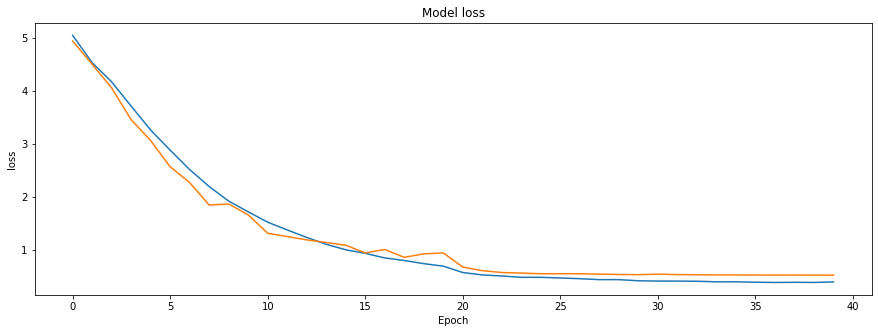

In [38]:
plt.figure(figsize=(15,5))
plt.plot(local_model.history['loss'])
plt.plot(local_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

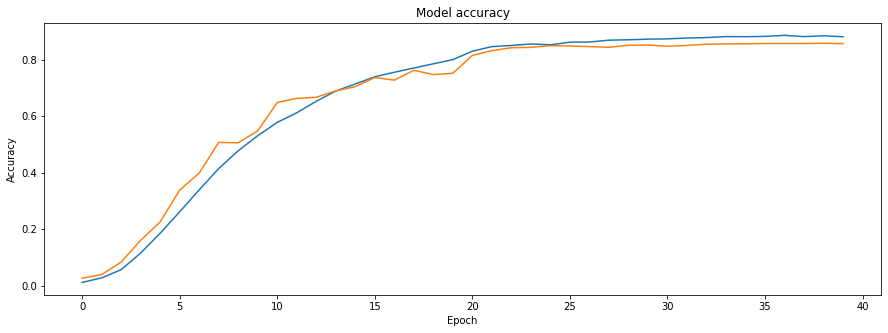

In [42]:
plt.figure(figsize=(15,5))
plt.plot(local_model.history['accuracy'])
plt.plot(local_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()